## 项目: 实现一个狗类品种识别算法的APP, 卷积神经网络(Convolutional Neural Network, CNN)

涉及: CNN, 迁移学习(VGG16, ResNet50, etc), Keras(TF后端), Keras Sequence模型, sklearn.datasets.load_files, np_utils.to_categorical, cv2.CascadeClassifier, matplotlib.pyplot, keras.applications.resnet50, paths_to_tensor, keras.layers, keras.models, model.summary(), model.compile(), model.fit(), model.load_weights(), ModelCheckpointer(), bottleneck_features, npz文件, VGG19, ResNet50, Inception, Xception.

---

### 项目背景

此项目实现的功能可以作为移动端或Web应用程序的算法的一部分, 在项目的最后, 用户可以提供图像, 然后如果项目程序可以从图像中检测到一只狗, 它会输出狗的品种的预测, 如果图像包含的是一个人的脸, 它会预测一个与其最相似的狗的品种. 在现实世界中，你需要拼凑一系列的模型来完成不同的任务；举个例子，用来预测狗种类的算法会与预测人类的算法不同。在做项目的过程中，你可能会遇到不少失败的预测，因为并不存在完美的算法和模型. 下面这张图展示了完成项目后可能的输出结果:

![Sample Dog Output](images/sample_dog_output.png)


### 项目内容

我们将这个notebook分为不同的步骤，你可以使用下面的链接来浏览此notebook。

* [Step 0](#step0): 导入数据集, 狗狗的和人的
* [Step 1](#step1): 检测人脸
* [Step 2](#step2): 检测狗狗
* [Step 3](#step3): 从头创建一个CNN来分类狗品种
* [Step 4](#step4): 使用一个CNN来区分狗的品种(使用迁移学习)
* [Step 5](#step5): 建立一个CNN来分类狗的品种(使用迁移学习)
* [Step 6](#step6): 完成你的算法
* [Step 7](#step7): 测试你的算法

在该项目中包含了如下的问题：

* [问题 1](#question1) [问题 2](#question2) [问题 3](#question3) [问题 4](#question4) [问题 5](#question5) [问题 6](#question6)
* [问题 7](#question7) [问题 8](#question8) [问题 9](#question9) [问题 10](#question10) [问题 11](#question11)

---
<a id='step0'></a>
## 步骤 0: 导入狗种类的数据集

In [1]:
# 导入狗种类识别的(图像)数据集, 使用scikit-learn库的'load_files函数'来获取以下变量:
# 包含所有图像的文件路径的numpy数组: train_files, valid_files, test_files
# 包含独热编码分类标签的numpy数组: train_targets, valid_targets, test_targets
# 由字符串构成的与标签相对应的狗的种类: dog_names
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# 加载train, test和validation数据集的图像file和对应target标签;
def load_dataset(path):
    data        = load_files(path)
    # 具体路径到文件名为止;
    dog_files   = np.array(data['filenames'])
    # 库函数默认: 
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    # 返回对应的'图像文件(数组形式)'和'对应的标签'的np.array;
    return dog_files,dog_targets

# 加载train, test和validation文件路径和标签;
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files,  test_targets  = load_dataset('dogImages/test')
# 加载狗品种列表, item='dogImages/train/001.Affenpinscher/';
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# 打印数据统计描述
print('There are %d total dog categories.' % len(dog_names))
# 逻辑: 有几个文件路径, 就有几个文件, hstack: 数组内元素'堆叠';
print('There are %s total dog images.\n'   % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.'  % len(train_files))
print('There are %d validation dog images.'% len(valid_files))
print('There are %d test dog images.'      % len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [7]:
from glob import glob
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
print(dog_names)  # ['Affenpinscher', 'Afghan_hound', ...]
item_names = [item for item in sorted(glob("dogImages/train/*/"))]
print(item_names) # ['dogImages/train/001.Affenpinscher/', 'dogImages/train/002.Afghan_hound/', ...]

In [2]:
train_files  # 只是些路径;

array(['dogImages/train/095.Kuvasz/Kuvasz_06442.jpg',
       'dogImages/train/057.Dalmatian/Dalmatian_04054.jpg',
       'dogImages/train/088.Irish_water_spaniel/Irish_water_spaniel_06014.jpg',
       ..., 'dogImages/train/029.Border_collie/Border_collie_02069.jpg',
       'dogImages/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03261.jpg',
       'dogImages/train/048.Chihuahua/Chihuahua_03416.jpg'], 
      dtype='<U99')

In [3]:
# 导入人脸数据集: 人脸文件所在路径存储在名为'human_files'的numpy数组;
import random
random.seed(8675309)
# 加载打乱后的人脸数据集的文件名;
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)  # shuffle的是数组中的元素: 即文件路径;
# 显示数据集的数据量;
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## 步骤 1: 检测人脸
 
使用OpenCV的[Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html)来检测图像中的人脸.

OpenCV提供了很多预训练的人脸检测模型, 它们以XML文件保存在[github](https://github.com/opencv/opencv/tree/master/data/haarcascades).

我们使用其中一个模型, 它已经存储在`haarcascades`目录中.

Number of faces detected: 1


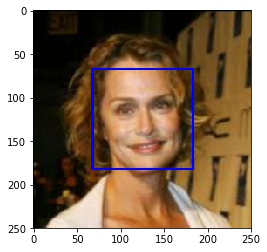

In [4]:
# 此Cell演示如何使用这个Haar检测模型在样例图像中找到人脸.
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# 将图像转换为灰度图是使用任何一个检测模型的常用过程, detectMultiScale函数使用储存在face_cascade中的数据, 对输入的灰度图像进行分类.
# 下面的faces变量是numpy数组, 它的每一行表示一个被检测到的脸: 前两个元素x和y代表识别框左上角的x和y坐标(参照下图), 
# 后两个元素代表识别框在x和y轴两个方向延伸的长度w和d. 
# 提取预训练的人脸检测模型
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
img   = cv2.imread(human_files[3])             # 加载彩色(通道顺序为BGR)图像
gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 将BGR图像进行灰度处理
faces = face_cascade.detectMultiScale(gray)    # 在图像中找出脸: (x,y,w,h)的形式, numpy数组
print('Number of faces detected:', len(faces)) # 打印图像中检测到的脸的个数

for (x,y,w,h) in faces:                        # 获取每一个所检测到的脸的识别框
    # 在人脸图像中绘制出识别框
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 将BGR图像转变为RGB图像以打印
plt.imshow(cv_rgb)                             # 展示含有识别框的图像
plt.show()

In [5]:
# 定义人脸识别器函数, 函数输入为人脸图像的路径, 当图像中包含人脸时, 该函数返回True, 否则返回False; 
def face_detector(img_path):
    img   = cv2.imread(img_path)
    gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### 评估人脸检测模型

<a id='question1'></a>
### __问题 1:__ 测试人脸的比例

理想情况下，人图像中检测到人脸的概率应当为100%，而狗图像中检测到人脸的概率应该为0%. 
然而算法并非完美，但结果是可以接受的.

In [6]:
# 从每个数据集中提取前100个图像的文件路径, 并存储为变量;
human_files_short = human_files[:100]
dog_files_short   = train_files[:100]
## TODO: 基于human_files_short和dog_files_short中的图像测试face_detector函数的表现;
facesInHuman = 0
facesInDog   = 0
for i in range(100):
    if face_detector(human_files_short[i]):
        facesInHuman += 1
    if face_detector(dog_files_short[i]):
        facesInDog += 1

In [7]:
print("Faces Per 100 Human Files: %d" % facesInHuman)
print("Faces Per 100 Dog Files: %d" % facesInDog)

Faces Per 100 Human Files: 98
Faces Per 100 Dog Files: 11


<a id='question2'></a>
### __问题 2:__ 

就算法而言，该算法成功与否的关键在于，用户能否提供含有清晰面部特征的人脸图像。
那么你认为，这样的要求在实际使用中对用户合理吗？如果你觉得不合理，你能否想到一个方法，即使图像中并没有清晰的面部特征，也能够检测到人脸？

__回答:__ 不合理, 有时即便是清晰照片中的人脸, 也会因为人脸出现的位置较远而很小, 或者模糊. 或许我们不用储存在face_cascade中的数据来检测人脸, 而是使用训练过的CNN模型来检测人脸.


In [5]:
# (选做): 报告另一个面部检测算法在LFW数据集上的表现;
# 建议在你的算法中使用opencv的人脸检测模型去检测人类图像，可以自由地探索其他的方法，尤其是尝试使用深度学习。
# 请用下方的代码单元来设计和测试你的面部监测算法。如果你决定完成这个_选做_任务，你需要报告算法在每一个数据集上的表现。

<a id='step2'></a>

## 步骤 2: 检测狗狗

这个部分中，我们使用预训练的 [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) 模型去检测图像中的狗。下方的第一行代码就是下载了 ResNet-50 模型的网络结构参数，以及基于 [ImageNet](http://www.image-net.org/) 数据集的预训练权重。ImageNet 这目前一个非常流行的数据集，常被用来测试图像分类等计算机视觉任务相关的算法。它包含超过一千万个 URL，每一个都链接到 [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 中所对应的一个物体的图像(当然包含我们需要的狗咯)。任给输入一个图像，该 ResNet-50 模型会返回一个对图像中物体的预测结果。

In [8]:
# 使用现成的模型:ResNet50(keras自带), 以及数据集:ImageNet;
from keras.applications.resnet50 import ResNet50
# 定义基于ImageNet数据集的ResNet50模型;
ResNet50_model = ResNet50(weights='imagenet')

### 数据预处理

- Keras在使用TensorFlow作为后端的时候，CNN的输入是一个4维数组(即4维张量), 它的各维度尺寸为`(nb_samples, rows, columns, channels)`。其中`nb_samples`表示图像(或者样本)的总数, `rows`, `columns`和`channels`分别表示图像的行数、列数和通道数。

- `path_to_tensor()`函数的输入是彩色图像的字符串型的文件路径, 返回的是一个4维张量, 作为Keras(TF作为后端) CNN的输入, 因输入图像是彩色图像, 因此`channels`为`3`:
    1. 该函数首先读取一张图像，然后将其缩放为 224×224 的图像。
    2. 随后，该图像被调整为具有4个维度的张量。
    3. 对于任一输入图像，最后返回的张量的维度是：`(1, 224, 224, 3)`。

- `paths_to_tensor()`函数将图像路径的字符串组成的 numpy 数组作为输入，并返回一个4维张量，各维度尺寸为 `(nb_samples, 224, 224, 3)`。 在这里，`nb_samples`是提供的图像路径的数据中的样本数量或图像数量。你也可以将 `nb_samples` 理解为数据集中3维张量的个数（每个3维张量表示一个不同的图像。

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

# 基本tensor转换操作;
def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型;
    img = image.load_img(img_path, target_size=(224, 224))
    x   = image.img_to_array(img)    # 将PIL.Image.Image类型转化为格式为(224, 224, 3)的3维张量
    return np.expand_dims(x, axis=0) # 将3维张量转化为格式为(1, 224, 224, 3)的4维张量并返回;

# 合成tensor操作;
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors) # (nb_samples,224,224,3);

### 基于 ResNet-50 架构进行预测

对于通过上述步骤得到的四维张量，在把它们输入到 ResNet-50 网络、或 Keras 中其他类似的预训练模型之前，还需要进行一些额外的处理：
1. 首先，这些图像的通道顺序为 RGB，我们需要重排他们的通道顺序为 BGR。
2. 其次，预训练模型的输入都进行了额外的归一化过程。因此我们在这里也要对这些张量进行归一化，即对所有图像所有像素都减去像素均值 `[103.939, 116.779, 123.68]`（以 RGB 模式表示，根据ImageNet中的所有图像算出）。

导入的 `preprocess_input` 函数实现了这些功能。如果你对此很感兴趣，可以在 [这里](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py) 查看 `preprocess_input`的代码。


在实现了图像处理的部分之后，我们就可以使用模型来进行预测。这一步通过 `predict` 方法来实现，它返回一个向量，向量的第 i 个元素表示该图像属于第 i 个 ImageNet 类别的概率。这通过如下的 `ResNet50_predict_labels` 函数实现。

通过对预测出的向量取用 argmax 函数（找到有最大概率值的下标序号），我们可以得到一个整数，即模型预测到的物体的类别。根据这个[清单](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)，我们能够知道这具体是哪个品种的狗狗。


In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path)) # 预处理好一张图片;
    # print(img.shape)  # Shape: (1,224,224,3);
    return np.argmax(ResNet50_model.predict(img))    # 返回图像的预测向量(index关联狗狗种类);

### 完成狗检测模型

在研究该 [清单](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 的时候，你会注意到，狗类别对应的序号为151-268。因此，在检查预训练模型判断图像是否包含狗的时候，我们只需要检查如上的 `ResNet50_predict_labels` 函数是否返回一个介于151和268之间（包含区间端点）的值。

In [11]:
# 狗狗判断: 如果从图像中检测到狗就返回True，否则返回False;
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### 评估狗狗检测模型

<a id='question3'></a>
### __问题 3:__ 

在下方的代码块中，使用 `dog_detector` 函数，计算：

- `human_files_short`中图像检测到狗狗的百分比？
- `dog_files_short`中图像检测到狗狗的百分比？

In [6]:
# TODO: 测试dog_detector函数在human_files_short和dog_files_short的表现, 对标之前的face_detector();
dogsInHuman = 0
dogsInDog   = 0
for i in range(100):
    if dog_detector(human_files_short[i]):
        dogsInHuman += 1
    if dog_detector(dog_files_short[i]):
        dogsInDog   += 1

In [13]:
print("Dogs Percentage in human_files_short: %d%%" % dogsInHuman)
print("Dogs Percentage in dog_files_short: %d%%" % dogsInDog)

Dogs Percentage in human_files_short: 1%
Dogs Percentage in dog_files_short: 100%


<a id='step3'></a>

## 步骤 3: 从头开始创建一个CNN来分类狗品种


现在我们已经实现了两个函数, 能够在图像中识别人类及狗狗(`face_detector()`和`dog_detector()`), 但我们需要更进一步的方法，来对狗的类别进行识别。在这一步中，你需要实现一个卷积神经网络来对狗的品种进行分类。你需要__从头实现__你的卷积神经网络（在这一阶段，你还不能使用迁移学习），并且你需要达到超过1%的测试集准确率。在步骤5中，你还有机会使用迁移学习来实现一个准确率大大提高的模型。

**关于训练时间的估计**: 在添加卷积层的时候，注意不要加上太多的(可训练的)层, 更多的参数意味着更长的训练时间，也就是说你更可能需要一个 GPU 来加速训练过程。万幸的是，Keras 提供了能够轻松预测每次迭代（epoch）花费时间所需的函数, 你可以据此推断你算法所需的训练时间。

值得注意的是，对狗的图像进行分类是一项极具挑战性的任务。因为即便是一个正常人，也很难区分布列塔尼犬和威尔士史宾格犬。


布列塔尼犬（Brittany） | 威尔士史宾格犬（Welsh Springer Spaniel）
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

不难发现其他的狗品种会有很小的类间差别（比如金毛寻回犬和美国水猎犬）。


金毛寻回犬（Curly-Coated Retriever） | 美国水猎犬（American Water Spaniel）
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

同样，拉布拉多犬（labradors）有黄色、棕色和黑色这三种。那么你设计的基于视觉的算法将不得不克服这种较高的类间差别，以达到能够将这些不同颜色的同类狗分到同一个品种中。

黄色拉布拉多犬（Yellow Labrador） | 棕色拉布拉多犬（Chocolate Labrador） | 黑色拉布拉多犬（Black Labrador）
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

我们也提到了随机分类将得到一个非常低的结果：不考虑品种略有失衡的影响，随机猜测到正确品种的概率是1/133，相对应的准确率是低于1%的. (在深度学习领域, 实践远远高于理论: 可以大量尝试不同的框架)

### 数据预处理

通过对每张图像的像素值除以255，我们对图像实现了归一化处理(联想"归零", 归一: 区间[0,1])。

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
# tensor中同样可以归一: 此处tensor就是以int或float为基础类型的高层数据类型;
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors  = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:15<00:00, 52.90it/s]


### 模型架构(CNN: 卷积, 池化, 丢弃, 全连接)

创建一个卷积神经网络来对狗品种进行分类, 在你代码块的最后, 执行`model.summary()`来输出你模型的总结信息(Keras语法)。 小提示: 该模型能够在5个epoch内取得超过1%的测试准确率，并且能在CPU上很快地训练(如有需要还可以自行导入所需Python库)。

![Sample CNN](images/sample_cnn.png)

---

<a id='question4'></a>  

### __问题 4:__ 

在下方的代码块中尝试使用 Keras 搭建卷积网络的架构，并回答相关的问题。

1. 你可以尝试自己搭建一个卷积网络的模型，那么你需要回答你搭建卷积网络的具体步骤（用了哪些层）以及为什么这样搭建。
2. 你也可以根据上图提示的步骤搭建卷积网络，那么请说明为何如上的架构能够在该问题上取得很好的表现。

__回答:__ 

2.一般的图像CNN模型, 在卷积层后面会添加池化层以降噪, 而在经过几轮的特征提取(卷积+池化)形成特征抽象(全局平均池化)之后, 会生成feature vector, 不同的物体有不同的feature vector值, 最终网络的分类根据此层信息进行(dense全连接层).


In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
model = Sequential()
# 定义网络结构;
# kernel_size=3;
model.add(Conv2D(filters=16, kernel_size=2, strides=1, activation='relu', padding='valid', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=32, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(units=133, activation='softmax'))  # activation value: default(linear), relu, etc.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
__________

In [26]:
## 编译模型
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## 【练习】训练模型

<a id='question5'></a>  
### __问题 5:__ 

在下方代码单元训练模型。使用模型检查点（model checkpointing）来储存具有最低验证集 loss 的模型. **Optional**: 你也可以对训练集进行[数据增强](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), 来优化模型的表现.

In [35]:
from keras.callbacks import ModelCheckpoint  
# 设置训练模型的epochs的数量
epochs = 6  # None,5;
# 训练模型;
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', verbose=1, save_best_only=True)
model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/6
6680/6680 [==============================] - 254s - loss: 4.8838 - acc: 0.0106 - val_loss: 4.8702 - val_acc: 0.0108
Epoch 2/6
6680/6680 [==============================] - 243s - loss: 4.8554 - acc: 0.0147 - val_loss: 4.8354 - val_acc: 0.0192
Epoch 3/6
6680/6680 [==============================] - 240s - loss: 4.8083 - acc: 0.0186 - val_loss: 4.8023 - val_acc: 0.0204
Epoch 4/6
6680/6680 [==============================] - 252s - loss: 4.7711 - acc: 0.0208 - val_loss: 4.7864 - val_acc: 0.0204
Epoch 5/6
6680/6680 [==============================] - 243s - loss: 4.7439 - acc: 0.0229 - val_loss: 4.7600 - val_acc: 0.0251
Epoch 6/6
6680/6680 [==============================] - 255s - loss: 4.7145 - acc: 0.0241 - val_loss: 4.7436 - val_acc: 0.0204


In [27]:
# 加载具有最好验证loss的模型;
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### 测试模型

在狗图像的测试数据集上试用你的模型。确保测试准确率大于1%。

In [28]:
# 获取测试数据集中每一个图像所预测的狗品种的index;
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
# 报告测试准确率: 正确个数/总数, 再乘以100(用于显示值在百分号中);
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.3493%


<a id='step4'></a>
## 步骤 4: 使用迁移学习来训练区分狗品种的CNN

使用 迁移学习（Transfer Learning）的方法，能帮助我们在不损失准确率的情况下大大减少训练时间。

In [29]:
# 得到从图像中提取的特征向量(Bottleneck Features), 即卷积之后的特征向量;
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
# 迁移: 直接使用bottleneck_features获取要直接迁移得到的特征, 用于之后的训练;
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16  = bottleneck_features['test']

### 迁移模型结构 - VGG-16

该模型使用预训练的 VGG-16 模型作为固定的图像特征提取器，其中 VGG-16 最后一层卷积层的输出被直接输入到我们的模型。我们只需要添加一个全局平均池化层以及一个全连接层，其中全连接层使用 softmax 激活函数，每一个狗的种类都包含一个节点。

In [30]:
print(train_VGG16.shape[1:])
print(train_VGG16.shape[:])

(7, 7, 512)
(6680, 7, 7, 512)


In [31]:
VGG16_model = Sequential()
# 添加迁移学习中需要学习的网络层;
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))
VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


In [32]:
## 编译模型
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [44]:
## 训练模型
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', verbose=1, save_best_only=True)
# train_VGG16相当于训练的数据, 只不过是直接迁移而来的bottleneck_feature(是我们想要的);
VGG16_model.fit(train_VGG16, train_targets, validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s - loss: 11.9594 - acc: 0.1229 - val_loss: 10.1233 - val_acc: 0.2467
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 9.5069 - acc: 0.3045 - val_loss: 9.4817 - val_acc: 0.3030
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 8.9626 - acc: 0.3681 - val_loss: 9.1578 - val_acc: 0.3353
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 8.7635 - acc: 0.4046 - val_loss: 9.0589 - val_acc: 0.3605
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 8.6571 - acc: 0.4283 - val_loss: 9.0384 - val_acc: 0.3689
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.5812 - acc: 0.4416 - val_loss: 9.0060 - val_acc: 0.3737
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.5437 - acc: 0.4500 - val_loss: 9.0669 - val_acc: 0.3760
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.5060 - 

In [33]:
# 加载具有最好验证loss的模型: VGG16;
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### 测试模型
现在，我们可以测试此VGG16 CNN在狗图像测试数据集中识别品种的效果如何.

In [34]:
# 获取测试数据集中每一个图像所预测的狗品种的index
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]
# 报告测试准确率
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 40.6699%


### 使用VGG16模型预测狗的品种

In [35]:
from extract_bottleneck_features import *
def VGG16_predict_breed(img_path):
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))  # 提取bottleneck特征
    predicted_vector   = VGG16_model.predict(bottleneck_feature)  # 获取预测向量
    return dog_names[np.argmax(predicted_vector)]                 # 返回此模型预测的狗的品种

<a id='step5'></a>
## 步骤 5: 建立一个CNN来分类狗的品种(使用迁移学习, 之前使用了VGG16)

现在你将使用迁移学习来建立一个CNN，从而可以从图像中识别狗的品种。你的 CNN 在测试集上的准确率必须至少达到60%。

在步骤4中，我们使用了迁移学习来创建一个使用基于 VGG-16 提取的特征向量来搭建一个 CNN。在本部分内容中，你必须使用另一个预训练模型来搭建一个 CNN。为了让这个任务更易实现，我们已经预先对目前 keras 中可用的几种网络进行了预训练：

- [VGG-19](https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd101/DLND+documents/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd101/DLND+documents/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd101/DLND+documents/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd101/DLND+documents/DogXceptionData.npz) bottleneck features

这些文件被命名为为：

    Dog{network}Data.npz

其中 `{network}` 可以是 `VGG19`、`Resnet50`、`InceptionV3` 或 `Xception` 中的一个。选择上方网络架构中的一个，下载相对应的bottleneck特征，并将所下载的文件保存在目录 `bottleneck_features/` 中。


### 【练习】获取模型的特征向量

在下方代码块中，通过运行下方代码提取训练、测试与验证集相对应的bottleneck特征。

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [36]:
# 从另一个预训练的CNN获取bottleneck特征: ResNet50;
bottleneck_features_ResNet_50 = np.load('bottleneck_features/DogResNet50Data.npz')
train_ResNet_50 = bottleneck_features_ResNet_50['train']
valid_ResNet_50 = bottleneck_features_ResNet_50['valid']
test_ResNet_50  = bottleneck_features_ResNet_50['test']

### 【练习】模型架构

建立一个CNN来分类狗品种。在你的代码单元块的最后，通过运行如下代码输出网络的结构：
    
        <your model's name>.summary()
   
---

<a id='question6'></a>  

### __问题 6:__ 


在下方的代码块中尝试使用 Keras 搭建最终的网络架构，并回答你实现最终 CNN 架构的步骤与每一步的作用，并描述你在迁移学习过程中，使用该网络架构的原因。


__回答:__ 

在我新建的模型中, 模型的输入是已训练过的ResNet-50模型的前三组"卷积+池化"层的结果, 而在这之后, 我连接了一个"全局平均池化"层, 这一层用来形成一个"feature vector", 而后, 我再用了一个"全连接"层(Dense层), 用于将"feature vector"中的抽象特征结果进行线性组合, 并分类成最终狗狗的品种.

ResNet50使用了ImageNet数据集进行预训练, 数据集中包含了我们要预测的狗狗的种类数据, 并且该数据集也有不错的准确率, 故在迁移学习中, 我们可以使用该预训练模型的前面特征提取的部分网络, 而自己添加的全连接层用于将已提取的特征分类成结果. 



In [37]:
print(train_ResNet_50.shape[1:])
print(train_ResNet_50.shape[:])

(1, 1, 2048)
(6680, 1, 1, 2048)


In [38]:
# 定义框架, Bug: 之前有的"ResNet50_model", 这里不能覆盖掉;
ResNet50_model_my = Sequential()
ResNet50_model_my.add(GlobalAveragePooling2D(input_shape=train_ResNet_50.shape[1:]))
ResNet50_model_my.add(Dense(133, activation='softmax'))  # 简记: 有softmax, 即求占比;
ResNet50_model_my.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


In [39]:
### TODO: 编译模型
ResNet50_model_my.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### 【练习】训练模型

<a id='question7'></a>  
### __问题 7:__ 

在下方代码单元中训练你的模型。使用模型检查点（model checkpointing）来储存具有最低验证集 loss 的模型。当然，你也可以对训练集进行 [数据增强](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) 以优化模型的表现，不过这不是必须的步骤。

In [67]:
from keras.callbacks import ModelCheckpoint 
# 训练模型;
checkpointer_ResNet50 = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', verbose=1, save_best_only=True)
# 在训练中注意: 注册保存最佳模型的callbacks, 原理, 它会在训练过程中跟踪ResNet50_model_my的表现;
ResNet50_model_my.fit(train_ResNet_50, train_targets, validation_data=(valid_ResNet_50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer_ResNet50], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 9s - loss: 1.6339 - acc: 0.5949 - val_loss: 0.8133 - val_acc: 0.7377
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 0.4345 - acc: 0.8608 - val_loss: 0.7326 - val_acc: 0.7521
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 0.2685 - acc: 0.9124 - val_loss: 0.7369 - val_acc: 0.7844
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 0.1715 - acc: 0.9457 - val_loss: 0.7320 - val_acc: 0.7952
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 0.1245 - acc: 0.9636 - val_loss: 0.6702 - val_acc: 0.8132
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 0.0882 - acc: 0.9741 - val_loss: 0.6854 - val_acc: 0.8132
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 0.0641 - acc: 0.9798 - val_loss: 0.7166 - val_acc: 0.8060
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 0.0487 - ac

In [40]:
### TODO: 加载具有最佳验证loss的模型权重
ResNet50_model_my.load_weights('saved_models/weights.best.ResNet50.hdf5')

### 【练习】测试模型

<a id='question8'></a>  
### __问题 8:__ 

在狗图像的测试数据集上试用你的模型。确保测试准确率大于60%。

In [41]:
# 在测试集上计算分类准确率
# 获取测试数据集中每一个图像的预测狗品种的index结果, 即target;
ResNet50_predictions = [np.argmax(ResNet50_model_my.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet_50]
# 测试准确率;
test_accuracy_ResNet_50 = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy_ResNet_50)

Test accuracy: 80.8612%


---

### 【练习】使用模型测试狗的品种


实现一个函数，它的输入为图像路径，功能为预测对应图像的类别，输出为你模型预测出的狗类别（`Affenpinscher`, `Afghan_hound` 等）。

与步骤5中的模拟函数类似，你的函数应当包含如下三个步骤：

1. 根据选定的模型载入图像特征（bottleneck features）
2. 将图像特征输输入到你的模型中，并返回预测向量。注意，在该向量上使用 argmax 函数可以返回狗种类的序号。
3. 使用在步骤0中定义的 `dog_names` 数组来返回对应的狗种类名称。

提取图像特征过程中使用到的函数可以在 `extract_bottleneck_features.py` 中找到。同时，他们应已在之前的代码块中被导入。根据你选定的 CNN 网络，你可以使用 `extract_{network}` 函数来获得对应的图像特征，其中 `{network}` 代表 `VGG19`, `Resnet50`, `InceptionV3`, 或 `Xception` 中的一个。
 
---

<a id='question9'></a>  

### __问题 9:__

In [42]:
# 将图像的路径作为输入, 然后返回此(迁移)模型所预测的狗的品种;
def ResNet50_predict_breed(img_path):
    # 提取bottleneck特征
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # 使用迁移并训练过的模型预测向量
    predicted_vector = ResNet50_model_my.predict(bottleneck_feature)
    # 返回此模型预测的狗的品种
    # print("Dog Breed:")
    return dog_names[np.argmax(predicted_vector)]    

<a id='step6'></a>
## 步骤 6: 完成算法

实现一个算法，它的输入为图像的路径，它能够区分图像是否包含一个人、狗或两者都不包含，然后：

- 如果从图像中检测到一只__狗__，返回被预测的品种。
- 如果从图像中检测到__人__，返回最相像的狗品种。
- 如果两者都不能在图像中检测到，输出错误提示。

我们非常欢迎你来自己编写检测图像中人类与狗的函数，你可以随意地使用上方完成的 `face_detector` 和 `dog_detector` 函数。

你__需要__在步骤5使用你的CNN来预测狗品种。

下面提供了算法的示例输出，但也可以自由地设计模型！

![Sample Human Output](images/sample_human_output.png)

<a id='question10'></a>  
### __问题 10:__

完成下方代码块.

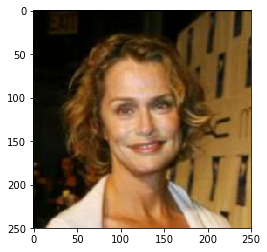

Hello, human!
You look like a,  Beagle


In [43]:
# 逻辑: 先预测是人还是狗, 然后plt图像, 然后输出: you look like a ... xxx;
def theFinalPredict(img_path):
    
    imgFinal = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(imgFinal)
    plt.show()
    
    if face_detector(img_path):
        print("Hello, human!")
        thePredict = ResNet50_predict_breed(img_path)
        print("You look like a, ", thePredict)
    elif dog_detector(img_path):
        print("Hello, doggy!")
        thePredict = ResNet50_predict_breed(img_path)
        print("You look like a, ", thePredict)
    else:
        print("Error: neithor human or doggy!")

# print("Demo")
theFinalPredict(human_files[3])

<a id='step7'></a>
## 步骤 7: 测试你的算法

<a id='question11'></a>  
### __问题 11:__

1. 输出结果比你预想的要好吗? 或者更糟?
2. 提出至少三点改进你的模型的想法。

**回答**:

1.输出的结果比预想中的要好, 除去强制将人的图片用于识别狗狗并生成结果的图片之外, 其余的预测结果都是正确的.

2.可能的改进方法:

    a.使用速度更快的模型生成'bottleneck_feature': 现在的情形是每次预测都需要5-10秒钟, 可以使用结构更简单且能保存准确率的结构;
    
    b.对于预测失败的品种, 使用更多的该类数据训练模型;
    
    c.设定一定的阈值, 对于小于该阈值的预测将不给出种类结果;
    
    d.修改运行结果的逻辑, 对于不是狗狗的图片, 不进行狗类品种的预测(如例子中人和猫的预测).

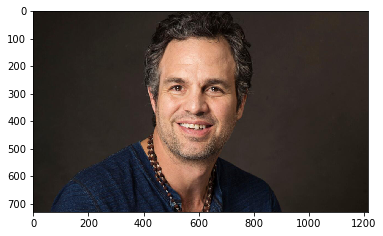

Hello, human!
You look like a,  Irish_water_spaniel


In [44]:
# 使用其它图片测试模型及应用;
human_files_test_1 = "images_for_test/01_Mark_Ruffalo.jpg" # human_files[100]
theFinalPredict(human_files_test_1)

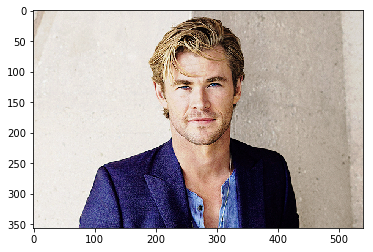

Hello, human!
You look like a,  Dogue_de_bordeaux


In [45]:
human_files_test_2 = "images_for_test/02_Chris_Hemsworth.jpg" # human_files[101]
theFinalPredict(human_files_test_2)

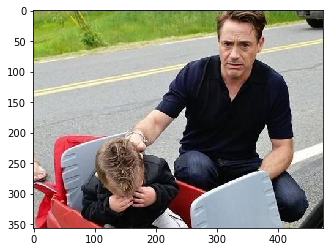

Hello, human!
You look like a,  Neapolitan_mastiff


In [46]:
human_files_test_3 = "images_for_test/03_Robert_Downey_Jr.jpeg" # human_files[102]
theFinalPredict(human_files_test_3)

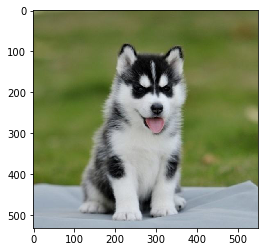

(1, 224, 224, 3)
Hello, doggy!
You look like a,  Alaskan_malamute


In [47]:
dog_files_test_1 = "images_for_test/04_Husky.jpeg" # train_files[100]
theFinalPredict(dog_files_test_1)

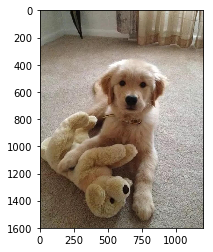

(1, 224, 224, 3)
Hello, doggy!
You look like a,  Golden_retriever


In [48]:
dog_files_test_2 = "images_for_test/05_Golden_Retriever.jpeg" # train_files[101]
theFinalPredict(dog_files_test_2)

In [52]:
print(dog_files_test_2.shape) # train_files[101]: (325, 325, 3)
print(train_files[101].shape) # ()

(325, 325, 3)
()


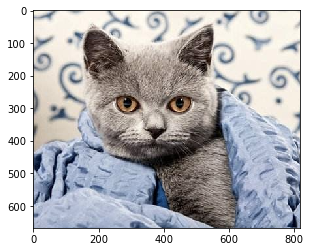

(1, 224, 224, 3)
Error: neithor human or doggy!


In [49]:
dog_files_test_3 = "images_for_test/06_British_Shorthair.png" # train_files[102]
theFinalPredict(dog_files_test_3)

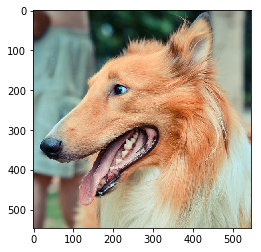

(1, 224, 224, 3)
Hello, doggy!
You look like a,  Collie


In [51]:
# 添加了新的狗狗的照片(网上获取, 非数据集中的图片);
new_dog_01 = "images_for_test/new_dog_01.jpg"
theFinalPredict(new_dog_01)

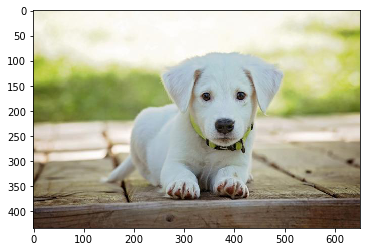

Hello, human!
You look like a,  Kuvasz


In [52]:
# 添加了新的狗狗的照片(网上获取, 非数据集中的图片);
new_dog_02 = "images_for_test/new_dog_02.jpg"
theFinalPredict(new_dog_02)